In [30]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transactions = pd.read_csv('transactions.csv')

In [3]:
transactions.amount = transactions.amount.apply(lambda x: round(x/11.2296))

In [4]:
train_transactions = transactions[transactions.amount < 0].copy()
train_transactions['day'] = train_transactions.tr_datetime.apply(lambda dt: dt.split()[0]).astype(int)

In [17]:
transactions.groupby("mcc_code").count().sort_values("amount", ascending = False).head(5)

,customer_id,tr_datetime,tr_type,amount,term_id
mcc_code,,,,,
6011,1447370,1447370,1447370,1447370,813381
6010,1021046,1021046,1021046,1021046,628841
4814,987181,987181,987181,987181,563980
5411,961860,961860,961860,961860,600493
4829,624643,624643,624643,624643,394888


* 6010, 6011 - снятие налички;
* 5411 - супермаркеты
* 4814 - звонки
* 4829 - переводы

In [5]:
train_transactions.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,day
0,39026145,0 10:23:26,4814,1030,-200.0,NaN,0
2,39026145,1 10:20:56,4829,2330,-5000.0,NaN,1
3,39026145,1 10:39:54,5499,1010,-124.0,NaN,1
4,39026145,2 15:33:42,5499,1010,-82.0,NaN,2
5,39026145,2 15:53:49,5541,1010,-1304.0,NaN,2


In [6]:
test_transactions = pd.DataFrame(columns=train_transactions.mcc_code.unique(), 
                                 index=np.arange(1, 31) + train_transactions.day.max())
test_transactions = test_transactions.unstack().reset_index().dropna(axis=1)
test_transactions.columns = ['mcc_code', 'day']

In [7]:
test_transactions.head()

,mcc_code,day
0,4814,457
1,4814,458
2,4814,459
3,4814,460
4,4814,461


In [8]:
train_grid = pd.DataFrame(columns=train_transactions.mcc_code.unique(), 
                          index=train_transactions.day.unique())
train_grid = train_grid.unstack().reset_index().dropna(axis=1)
train_grid.columns = ['mcc_code', 'day']

In [9]:
train_grid.head()

,mcc_code,day
0,4814,0
1,4814,1
2,4814,2
3,4814,3
4,4814,4


In [10]:
for tr_table in [train_transactions, test_transactions, train_grid]:
    tr_table['week_num'] = tr_table['day'] // 7
    tr_table['week_day'] = tr_table['day'] % 7
    tr_table['month_num'] = tr_table['day'] // 30
    tr_table['month_day'] = tr_table['day'] % 30

In [11]:
train_transactions = \
    pd.merge(train_grid,
             train_transactions.groupby(['day', 'week_num', 'week_day', 'month_num', 'month_day', 'mcc_code'])[['amount']]\
                 .sum().reset_index(),
             how='left').fillna(0)

# Explore how amount graph depends from day, week, month

In [74]:
nalik = train_transactions[train_transactions.mcc_code == 6011]
nalik.amount = nalik.amount.apply(lambda x: -x)

In [75]:
nalik.shape

(457, 7)

In [76]:
nalik = nalik.sort_values("day", ascending=True)

In [115]:
by_day = nalik.set_index(nalik.day).drop(["day"], axis=1)

### Plotting by day

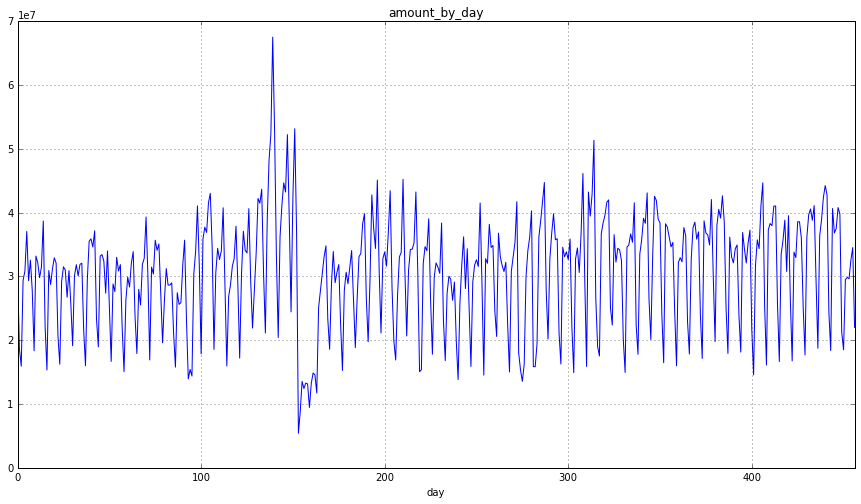

In [90]:
by_day.amount.plot(figsize=(15,8), grid=True, title="amount_by_day")

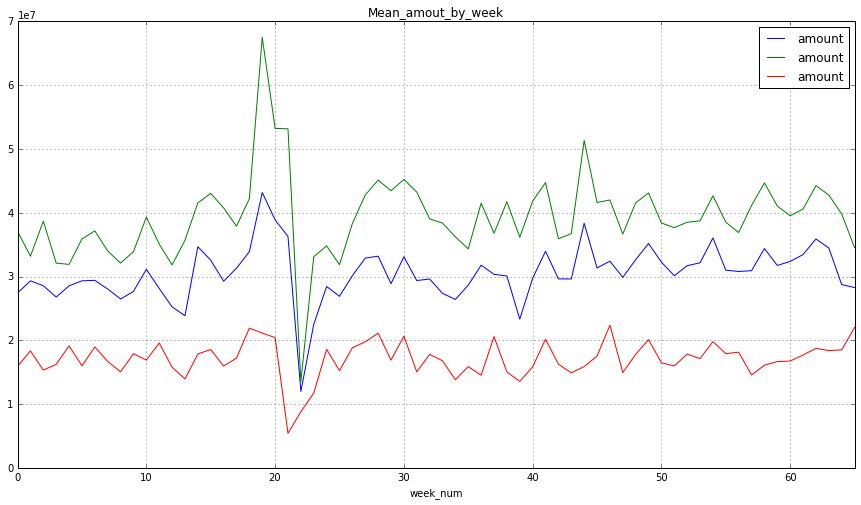

In [109]:
pd.concat([nalik.groupby("week_num").mean().amount, nalik.groupby("week_num").max().amount, nalik.groupby("week_num").min().amount], axis=1).plot(figsize=(15,8), grid=True, title="Mean_amout_by_week")

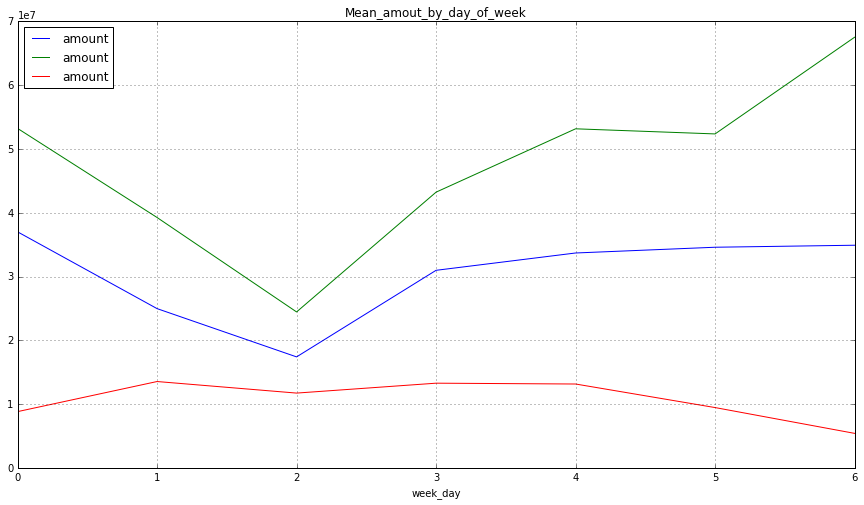

In [108]:
pd.concat([nalik.groupby("week_day").mean().amount, nalik.groupby("week_day").max().amount, nalik.groupby("week_day").min().amount], axis=1).plot(figsize=(15,8), grid=True, title="Mean_amout_by_day_of_week")

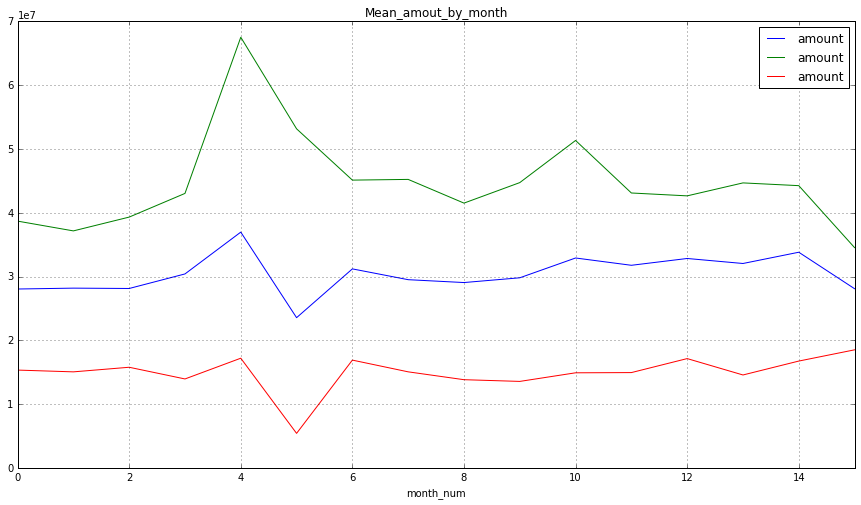

In [110]:
pd.concat([nalik.groupby("month_num").mean().amount, nalik.groupby("month_num").max().amount, nalik.groupby("month_num").min().amount], axis=1).plot(figsize=(15,8), grid=True, title="Mean_amout_by_month")

## Try ARMA?

In [111]:
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot


In [116]:
by_day = by_day.amount

day
0      30724878.0
1      18680505.0
2      15929873.0
3      29401266.0
4      30840904.0
5      37066248.0
6      29341739.0
7      32552249.0
8      27771338.0
9      18347286.0
10     33200963.0
11     32144840.0
12     29810866.0
13     31475836.0
14     38697955.0
15     22132301.0
16     15337415.0
17     30937086.0
18     28734988.0
19     31177656.0
20     32925088.0
21     32110775.0
22     20669759.0
23     16236959.0
24     29237553.0
25     31520864.0
26     30999216.0
27     26735985.0
28     30929370.0
29     25830129.0
          ...    
427    36025188.0
428    25208544.0
429    17697859.0
430    36162385.0
431    39682725.0
432    40588243.0
433    38813156.0
434    41117587.0
435    29505237.0
436    18752339.0
437    36408859.0
438    38886829.0
439    42354066.0
440    44258318.0
441    42795554.0
442    24383087.0
443    18393028.0
444    40663618.0
445    36814222.0
446    37531842.0
447    40814237.0
448    39812543.0
449    21244984.0
450    18512969.0
451   

In [117]:
by_day_diff = by_day.diff(periods=1).dropna()

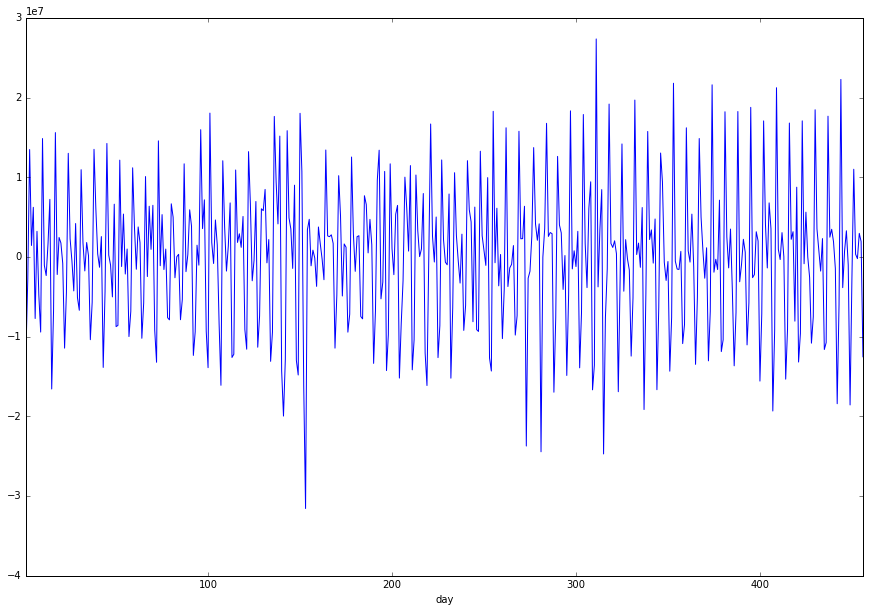

In [119]:
by_day_diff.plot(figsize=(15,10))

ряд первых разностей является стационарным, а наш исходный ряд — интегрированным рядом первого порядка.

### Построение модели временного ряда

Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.
Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:
p — порядок компоненты AR
d — порядок интегрированного ряда
q — порядок компонетны MA


Параметр d есть и он равет 1, осталось определить p и q. 

Для их определения нам надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.

ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA

PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.

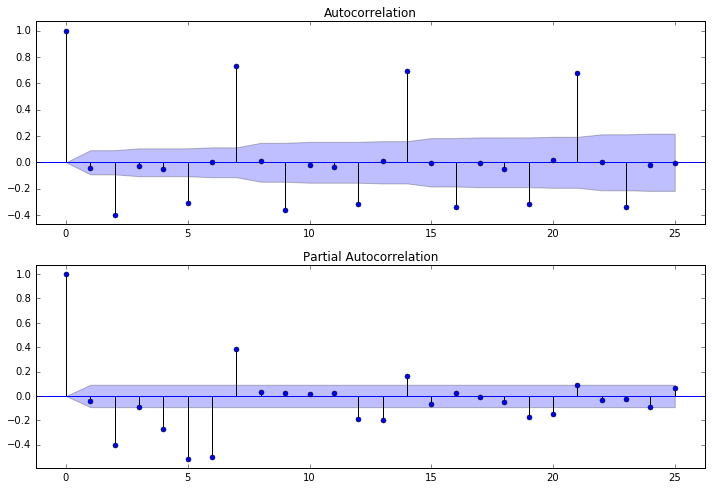

In [121]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(by_day_diff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(by_day_diff, lags=25, ax=ax2)

In [126]:
pd.to_datetime(by_day.index, unit='D')

DatetimeIndex(['1970-01-01', '1970-01-02', '1970-01-03', '1970-01-04',
               '1970-01-05', '1970-01-06', '1970-01-07', '1970-01-08',
               '1970-01-09', '1970-01-10',
               ...
               '1971-03-24', '1971-03-25', '1971-03-26', '1971-03-27',
               '1971-03-28', '1971-03-29', '1971-03-30', '1971-03-31',
               '1971-04-01', '1971-04-02'],
              dtype='datetime64[ns]', name=u'day', length=457, freq=None)

In [128]:
by_day.index = pd.to_datetime(by_day.index, unit='D')

In [130]:
by_day.head()

day
1970-01-01    30724878.0
1970-01-02    18680505.0
1970-01-03    15929873.0
1970-01-04    29401266.0
1970-01-05    30840904.0
Name: amount, dtype: float64

In [200]:
arma_mod30 = sm.tsa.ARMA(by_day, (20,1)).fit()

/Users/d.parpulov/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:443: RuntimeWarning: Inverting hessian failed, no bse or cov_params available
  warn(warndoc, RuntimeWarning)
/Users/d.parpulov/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [202]:
print(arma_mod30.params)

const            3.051563e+07
ar.L1.amount     8.761917e-01
ar.L2.amount    -3.150503e-01
ar.L3.amount     1.778076e-01
ar.L4.amount    -1.045427e-01
ar.L5.amount     1.622323e-01
ar.L6.amount    -9.978736e-02
ar.L7.amount     4.435007e-01
ar.L8.amount    -3.476138e-01
ar.L9.amount    -7.204246e-03
ar.L10.amount    3.880783e-03
ar.L11.amount   -3.604983e-03
ar.L12.amount   -4.472419e-02
ar.L13.amount   -5.916334e-02
ar.L14.amount    3.216226e-01
ar.L15.amount   -3.423948e-01
ar.L16.amount    1.315192e-01
ar.L17.amount   -7.853929e-02
ar.L18.amount   -8.230898e-03
ar.L19.amount   -1.124429e-01
ar.L20.amount    1.713573e-01
ma.L1.amount    -2.761005e-01
dtype: float64


In [203]:
predict_dynam = arma_mod30.predict('1971-03-02', '1971-04-02', dynamic=True)

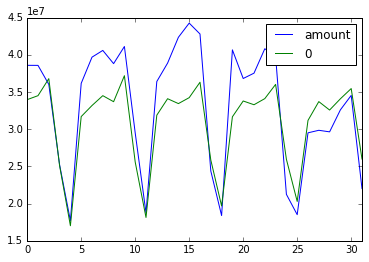

In [204]:
pd.concat([pd.DataFrame(by_day["1971-03-02":]).reset_index().drop(["day"], axis=1), pd.DataFrame(predict_dynam).reset_index().drop(["index"], axis=1)], axis=1).plot()

In [213]:
pred = np.array(pd.DataFrame(predict_dynam).reset_index().drop(["index"], axis=1)[0])

In [218]:
real = np.array(pd.DataFrame(by_day["1971-03-02":]).reset_index().drop(["day"], axis=1)["amount"])

In [219]:
def RMSLE(y_true,y_pred):
    return np.sqrt(np.sum(np.square(np.log(y_true + 500) - np.log(y_pred + 500)))/len(pred))

In [220]:
RMSLE(real, pred)

0.13475819776783668

In [13]:
for day_shift in [-1, 0, 1]:
    for month_shift in train_transactions.month_num.unique()[1:]:
        train_shift = train_transactions.copy()
        train_shift['month_num'] += month_shift
        train_shift['month_day'] += day_shift
        train_shift['amount_day_{}_{}'.format(day_shift, month_shift)] = np.log(-train_shift['amount'] + 1)
        train_shift = train_shift[['month_num', 'month_day', 'mcc_code', 'amount_day_{}_{}'.format(day_shift, month_shift)]]

        train_transactions = pd.merge(train_transactions, train_shift, 
                                      on=['month_num', 'month_day', 'mcc_code'], how='left').fillna(0)
        test_transactions = pd.merge(test_transactions, train_shift, 
                                     on=['month_num', 'month_day', 'mcc_code'], how='left').fillna(0)


In [14]:
train_transactions.head()

,mcc_code,day,week_num,week_day,month_num,month_day,amount,amount_day_-1_1,amount_day_-1_2,amount_day_-1_3,...,amount_day_1_6,amount_day_1_7,amount_day_1_8,amount_day_1_9,amount_day_1_10,amount_day_1_11,amount_day_1_12,amount_day_1_13,amount_day_1_14,amount_day_1_15
0,4814,0,0,0,0,0,-988349.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4814,1,0,1,0,1,-701880.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4814,2,0,2,0,2,-603537.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4814,3,0,3,0,3,-826205.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4814,4,0,4,0,4,-890483.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
day_for_train = train_transactions.day.max() - 30

In [16]:
X_train = train_transactions[train_transactions.day <= day_for_train]
X_val = train_transactions[train_transactions.day > day_for_train]

In [18]:
X_train.day.max(), X_val.day.min()

(426, 427)

In [19]:
shift = 500
train = pd.get_dummies(X_train, columns=['mcc_code'])
val = pd.get_dummies(X_val, columns=['mcc_code'])
test = pd.get_dummies(test_transactions, columns=['mcc_code'])

c = train.columns.difference(['amount'])

In [25]:
clf = LinearRegression(n_jobs=-1)
clf.fit(train[c], np.log(-train['amount'] + shift))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [26]:
pred = clf.predict(test[c])

In [27]:
pred.max()

210148419.3081736

In [28]:
np.sum(pred)

-20929744988.460541

In [29]:
def RMSLE(y_true,y_pred):
    return np.sqrt(np.sum(np.square(np.log(y_true + 500) - np.log(y_pred + 500)))/len(pred))

In [68]:
test_transactions['volume'] = np.e ** clf.predict(test[c]) - shift

## xgb

In [18]:
import xgboost as xgb

In [23]:
param = {}
param['max_depth'] = 5
param['booster'] = 'gbtree'
param['objective'] = 'reg:linear'
param['eval_metric'] = 'rmse'
param['eta'] = 0.05
param['subsample'] = 0.7
param['colsample_bytree'] = 0.8
param['colsample_bylevel'] = 0.8

numround = 100

In [31]:
%%time
model = xgb.XGBRegressor(max_depth=20, learning_rate=0.1, n_estimators=200, silent=False, \
                          objective='reg:linear', nthread=24, \
                          subsample=0.6, colsample_bytree=0.6, colsample_bylevel=0.7)
model.fit(train[c], np.log(-train['amount'] + shift))

XGBRegressor(base_score=0.5, colsample_bylevel=0.7, colsample_bytree=0.6,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=20,
       min_child_weight=1, missing=None, n_estimators=200, nthread=24,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=0.6)

In [32]:
test_transactions['volume'] = np.e ** model.predict(test[c]) - shift

In [33]:
test_transactions[['mcc_code', 'day', 'volume']].head()

,mcc_code,day,volume
0,4814,457,9228809.0
1,4814,458,11115197.0
2,4814,459,11007090.0
3,4814,460,9621389.0
4,4814,461,10203106.0


In [34]:
test_transactions[['mcc_code', 'day', 'volume']].to_csv('TASK2_baseline_xgb.csv', index=False)

In [70]:
test_transactions[['mcc_code', 'day', 'volume']].head()

,mcc_code,day,volume
0,4814,457,1.205250e+07
1,4814,458,1.227261e+07
2,4814,459,1.236170e+07
3,4814,460,1.225352e+07
4,4814,461,1.251162e+07


In [ ]:
test_transactions[['mcc_code', 'day', 'volume']].to_csv('baseline_b.csv', index=False)